In [ ]:
# Import core libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm

# Computer Vision
from PIL import Image
import albumentations as A

# PyTorch
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F

# Sci-kit Learn
import sklearn.model_selection

# To supress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Using Google Colab's GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

Using cuda


In [ ]:
train_data = torchvision.datasets.ImageFolder("../input/training_set/training_set/")

In [ ]:
class ImageLoader(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = ImageLoader(train_data.imgs, transform=transform)

### Training

The training of our model is normal, but for our validation strategy, we will be using cross validation.

**Validation Strategy**:

  For training, we will be doing K-Fold Cross Validation. Cross validation is a way to measure our model's performance in an accurate way. The technique uses a parameter called `k`. This parameter is the number of groups that a given data set is to be split into. 
    
  One of splits will be used for validation and the rest will be used for training. The next time around, another split will be used for validation and the rest will be used for training. This process will repeat. We will then average our results to see the performance of our model.

This technique is very popular since its unbiased and gives a good idea of how well our model performs.

In [ ]:
LEARNING_RATE = 0.01
BATCH_SIZE = 64
fold_info = {}

In [ ]:
def test_epoch(model, device, dataloader, criterion):
    model.eval()

    val_loss = 0.0
    val_correct = 0
    
    for batch_idx, (data, targets) in enumerate(dataloader):
      data = data.to(device)
      targets = targets.to(device)
      output = model(data)

      loss = criterion(output, targets)
      val_loss += loss.item() * data.size(0)
      
      _, predictions = torch.max(output.data, 1)
      val_correct += (predictions == targets).sum().item()

    return val_loss, val_correct

In [ ]:
def train_epoch(model, device, dataloader, criterion, optimizer):
    model.train()

    train_loss = 0.0
    train_correct = 0
    
    loop = tqdm(enumerate(dataloader), total=len(dataloader))

    for batch_idx, (data, targets) in loop:
      data = data.to(device)
      targets = targets.to(device)

      output = model(data)
      loss = criterion(output, targets)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * data.size(0)

      _, preds = torch.max(output.data, 1)
      train_correct += (preds == targets).sum().item()

      loop.set_description(f"Batch {int((batch_idx / len(dataloader)) * 100)}")
      loop.set_postfix(loss=loss.data.item())
        
    return train_loss, train_correct

In [ ]:
def train(num_epoch, k_folds, model_path="model.pth"):
  kf = sklearn.model_selection.KFold(n_splits=k_folds, shuffle=True, random_state=42)

  print("*"*50)   
  for fold, (train_idx,val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'Fold {fold + 1}')
    print("*"*50)

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

    model = torchvision.models.resnet50(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False

    num_of_filters = model.fc.in_features
    model.fc = nn.Linear(num_of_filters, 2)

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(0, num_epoch): 
        print(f"Epoch:{epoch+1}/{num_epoch}")  
        train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_correct = test_epoch(model, device, val_loader, criterion)

        train_count = len(train_loader.sampler)
        val_count = len(val_loader.sampler)

        train_loss = train_loss / train_count
        train_acc = (train_correct / train_count) * 100
        val_loss = val_loss / val_count
        val_acc = (val_correct / val_count) * 100
        
        print(f"Average Training Loss:{train_loss:.3f} | Average Validaton Loss:{val_loss:.3f}")
        print(f"Average Training Acc: {train_acc:.2f}% | Average Validaton Acc {val_acc:.2f}%")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print("\n", end="")

    fold_info[f'fold{fold+1}'] = {'train_acc':train_accuracies,
                                  'val_acc':val_accuracies,
                                  'val_loss':val_losses,
                                  'train_loss':train_losses}
    print("*"*50)

  torch.save(model, model_path)

In [ ]:
k_folds = 5
n_epochs = 5

train(n_epochs, k_folds=k_folds)

**************************************************
Fold 1
**************************************************
Epoch:1/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.35it/s, loss=0.000409]


Average Training Loss:0.182 | Average Validaton Loss:0.122
Average Training Acc: 94.53% | Average Validaton Acc 96.69%

Epoch:2/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.33it/s, loss=0.0219]


Average Training Loss:0.053 | Average Validaton Loss:0.168
Average Training Acc: 98.30% | Average Validaton Acc 95.13%

Epoch:3/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0.0108]


Average Training Loss:0.054 | Average Validaton Loss:0.052
Average Training Acc: 98.00% | Average Validaton Acc 98.38%

Epoch:4/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.35it/s, loss=3.83]


Average Training Loss:0.083 | Average Validaton Loss:1.620
Average Training Acc: 97.77% | Average Validaton Acc 76.20%

Epoch:5/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0]


Average Training Loss:0.483 | Average Validaton Loss:0.152
Average Training Acc: 94.60% | Average Validaton Acc 97.88%

**************************************************
Fold 2
**************************************************
Epoch:1/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0.00738]


Average Training Loss:0.170 | Average Validaton Loss:0.079
Average Training Acc: 94.22% | Average Validaton Acc 97.31%

Epoch:2/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0.0287]


Average Training Loss:0.056 | Average Validaton Loss:0.068
Average Training Acc: 97.97% | Average Validaton Acc 97.81%

Epoch:3/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.35it/s, loss=1.96]


Average Training Loss:0.164 | Average Validaton Loss:0.129
Average Training Acc: 96.10% | Average Validaton Acc 97.00%

Epoch:4/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0.0787]


Average Training Loss:0.140 | Average Validaton Loss:0.223
Average Training Acc: 96.88% | Average Validaton Acc 96.38%

Epoch:5/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0.249]


Average Training Loss:0.089 | Average Validaton Loss:0.088
Average Training Acc: 98.03% | Average Validaton Acc 98.06%

**************************************************
Fold 3
**************************************************
Epoch:1/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.35it/s, loss=0.0113]


Average Training Loss:0.345 | Average Validaton Loss:0.036
Average Training Acc: 91.72% | Average Validaton Acc 98.50%

Epoch:2/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.35it/s, loss=0.0289]


Average Training Loss:0.096 | Average Validaton Loss:0.064
Average Training Acc: 97.11% | Average Validaton Acc 97.81%

Epoch:3/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.35it/s, loss=0.00108]


Average Training Loss:0.057 | Average Validaton Loss:0.072
Average Training Acc: 98.06% | Average Validaton Acc 97.44%

Epoch:4/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0.0185]


Average Training Loss:0.086 | Average Validaton Loss:0.040
Average Training Acc: 97.50% | Average Validaton Acc 98.44%

Epoch:5/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.36it/s, loss=0.0636]


Average Training Loss:0.080 | Average Validaton Loss:0.097
Average Training Acc: 97.53% | Average Validaton Acc 97.31%

**************************************************
Fold 4
**************************************************
Epoch:1/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.35it/s, loss=0.0273]


Average Training Loss:0.213 | Average Validaton Loss:0.048
Average Training Acc: 93.79% | Average Validaton Acc 98.31%

Epoch:2/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.36it/s, loss=1.49]


Average Training Loss:0.104 | Average Validaton Loss:0.064
Average Training Acc: 97.11% | Average Validaton Acc 98.25%

Epoch:3/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.36it/s, loss=0]


Average Training Loss:0.127 | Average Validaton Loss:0.094
Average Training Acc: 97.08% | Average Validaton Acc 97.75%

Epoch:4/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0.039]


Average Training Loss:0.095 | Average Validaton Loss:0.057
Average Training Acc: 97.77% | Average Validaton Acc 98.50%

Epoch:5/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.35it/s, loss=3.98e-5]


Average Training Loss:0.084 | Average Validaton Loss:0.103
Average Training Acc: 98.03% | Average Validaton Acc 97.94%

**************************************************
Fold 5
**************************************************
Epoch:1/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.35it/s, loss=0.548]


Average Training Loss:0.459 | Average Validaton Loss:0.040
Average Training Acc: 90.94% | Average Validaton Acc 98.69%

Epoch:2/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.36it/s, loss=0.0514]


Average Training Loss:0.081 | Average Validaton Loss:0.053
Average Training Acc: 97.45% | Average Validaton Acc 98.25%

Epoch:3/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.36it/s, loss=0.161]


Average Training Loss:0.088 | Average Validaton Loss:0.061
Average Training Acc: 97.28% | Average Validaton Acc 97.75%

Epoch:4/5


Batch 99: 100%|██████████| 101/101 [01:14<00:00,  1.35it/s, loss=0.000962]


Average Training Loss:0.070 | Average Validaton Loss:0.049
Average Training Acc: 97.85% | Average Validaton Acc 98.25%

Epoch:5/5


Batch 99: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s, loss=0.751]


Average Training Loss:0.084 | Average Validaton Loss:0.727
Average Training Acc: 97.45% | Average Validaton Acc 86.88%

**************************************************


In [ ]:
val_losses, train_losses, val_accuracies, train_accuracies = [], [], [], []

for fold in range(1, k_folds+1):
  avg_train_loss = np.mean(fold_info[f'fold{fold}']['train_loss'])
  avg_val_loss = np.mean(fold_info[f'fold{fold}']['val_loss'])
  avg_train_accuracy = np.mean(fold_info[f'fold{fold}']['train_acc'])
  avg_val_accuracy = np.mean(fold_info[f'fold{fold}']['val_acc'])

  train_losses.append(avg_train_loss)
  val_losses.append(avg_val_loss)
  train_accuracies.append(avg_train_accuracy)
  val_accuracies.append(avg_val_accuracy)

print(f'Performance of {k_folds} fold cross validation:')
print(f"Average Training Loss: {np.mean(train_losses):.2f}")
print(f"Average Validation Loss: {np.mean(val_losses):.2f}")
print(f"Average Training Acc: {np.mean(train_accuracies):.2f}%")
print(f"Average Validation Acc: {np.mean(val_accuracies):.2f}%")

Performance of 5 fold cross validation:
Average Training Loss: 0.14
Average Validation Loss: 0.17
Average Training Acc: 96.52%
Average Validation Acc: 96.44%


In [ ]:
model = torch.load("model.pth") # load saved model from training

In [ ]:
# Predict on all the test
test_dataset = torchvision.datasets.ImageFolder("../input/test_set/test_set/", transform=transform)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle = False)

with torch.no_grad():
    model.eval()
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        print(f"Prediction: {predicted[0]}")

Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 1
Prediction: 1
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 1
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 1
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 1
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 0
Prediction: 1
Predic

KeyboardInterrupt: ignored

In [35]:
def predict(filepath):
  try:
    img_array = Image.open(filepath).convert("RGB")
    plt.imshow(img_array)
    img = transform(img_array).unsqueeze(dim=0) 
    load = torch.utils.data.DataLoader(img)
    for x in load:
        x = x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1) 
        if preds[0] == 1: 
          print(f"Prediction: Dog")
        else: 
          print(f"Prediction: Cat")
    plt.title("Image")
    plt.axis("off")
    plt.show()
  except FileNotFoundError as e:
    print("File not found!")

Prediction: Cat


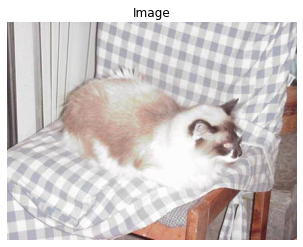

In [36]:
predict("../input/test_set/test_set/cats/cat.4011.jpg")

Prediction: Dog


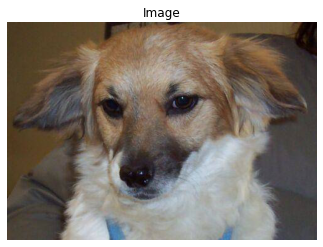

In [37]:
predict("../input/test_set/test_set/dogs/dog.4693.jpg")

### End Remarks
I learned a lot about PyTorch and cross validation in the mini-project. Our model also do very well as it is 96.44% accurate.